In [24]:
import sys
sys.path.append('..')
from load_expert_traj import Expert, ExpertHDF5, CircleExpertHDF5
import torch
from grid_world_gail import load_VAE_model
import argparse
import pickle
import os
config_path = 'context_20_history_3'
# config_path = 'centre_only_temp_1_0.1_context_4'
parser = argparse.ArgumentParser('predict and plot context for expert trajectories')
# paths
parser.add_argument('--expert_path', default='../h5_trajs/room_trajs/traj_room_centre_len_50') # expert_path = './h5_trajs/room_trajs/traj_len_16'
parser.add_argument('--vae_checkpoint_path', default=f'../results/vae/room_traj/discrete/{config_path}/checkpoint/cp_1000.pth')
parser.add_argument('--results_pkl_path', default=f'../results/test_predict/room_traj/{config_path}/pred_result_cp_1000.pth')
parser.add_argument('--results_dir', default=f'../results/test_predict/room_traj/{config_path}')
# parameter
parser.add_argument('--vae_state_size', default=4, type=int)
# trainig phase
parser.add_argument('--cuda', action='store_true')
parser.add_argument('--use_state_features', action='store_true')
parser.add_argument('-f')

args = parser.parse_args()


# load expert trajectories
expert = ExpertHDF5(args.expert_path, args.vae_state_size)
expert.push(only_coordinates_in_state=True, one_hot_action=True)

# load vae
vae_train = load_VAE_model(args.vae_checkpoint_path, args)
vae_train.set_expert(expert)
dtype = torch.FloatTensor

# forward expert trajectories
results = vae_train.test_generate_trajectory_variable_length(
                    expert,
                    num_test_samples=5,
                    test_goal_policy_only=False)

# save checkpoint
if not os.path.exists(args.results_dir):
    os.makedirs(args.results_dir)
with open(args.results_pkl_path, 'wb') as results_f:
    pickle.dump(results, results_f, protocol=2)
    print('Did save results to {}'.format(args.results_pkl_path))


Did load saved args ../results/vae/room_traj/discrete/context_20_history_3/args.pkl
Initial temperature: 1.0
Did load models at: ../results/vae/room_traj/discrete/context_20_history_3/checkpoint/cp_1000.pth
Batch reward mean: 0.000
Batch reward std: 0.000
Did save results to ../results/test_predict/room_traj/context_20_history_3/pred_result_cp_1000.pth


In [25]:
# % matplotlib inline

import numpy as np
import pandas as pd
import json
import sys
import os
import matplotlib
#matplotlib.use('Agg') 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
#import pdb
#import ipdb
import h5py
import importlib
import pickle

# Add root folder to sys path
sys.path.append("../")

# %pylab inline
# inline doesn't give interactive plots
# %matplotlib inline 
# %matplotlib notebook
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Blues'

sns.set()

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

# Import own modules
# Need to use importlib since module starts with a numerical value.

from load_expert_traj import Expert, ExpertHDF5
from grid_world import create_obstacles

plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots

In [26]:
def plot_data_n_colors_policy(data, grid_size, policy,
                              bounds=[-100, -0.5, 0.5, 1000],
                              color_map=['black', 'grey', 'red'],
                              save_path=''):
    
    cmap = matplotlib.colors.ListedColormap(color_map)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(data, cmap=cmap, norm=norm, extent=[0, grid_size, 0, grid_size],
              )

    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.grid(True)
    ax.autoscale(enable=False)

    for a, m in [(0, '>'), (1, 'v'), (2, '<'), (3, '^')]:
        if len(np.where(policy == a)) > 0:
            x, y = np.where(policy == a)
            # Why this weird math?
            # Original grid map has origin at top left (usual for images).
            # imshow (above) has a property `extent` which allows us to define the origin
            # location when rendering. But ax.scatter (below) doesn't have such an API,
            # it rather defines origin at  bottom left corner hence to convert to top left
            # we do the below math.
            ax.scatter(x=y + 0.5, y=grid_size - 1 - x + 0.5, c='r',
                       s=120, marker=m, edgecolors='none')
    if len(save_path) > 0:
        fig.savefig(save_path)
        
    fig.show()
    
def plot_trajectory(traj_data, grid_size,
                    pred_traj_data=None,
                    obstacles=None,
                    rooms=None,
                    pred_context=[],
                    pred_context_discrete=False,
                    bounds=[-100, -.5, .5, 100],
                    color_map=['black', 'grey', 'red'],
                    save_path='', figsize=(6,6), show_expert=False):
    cmap = matplotlib.colors.ListedColormap(color_map)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    img_arr = np.ones(grid_size)
    if obstacles is not None:
        for o in obstacles:
            img_arr[o[1], o[0]] = 0.0
    ax.imshow(img_arr, 
              cmap=cmap,
              norm=norm,
              extent=[0, grid_size[1], 0, grid_size[0]],
              interpolation='none', aspect='equal', origin='lower',
              )

    ax.set_xticks(range(grid_size[1]))
    ax.set_yticks(range(grid_size[0]))
    ax.grid(True)
    
    # Get context colors
    if pred_context_discrete and len(pred_context) > 0:
        num_discrete = len(pred_context[0])
        context_colors = ['g', 'blue', 'y', 'black', 'k', 'w','c', 'm', 'red','orange']
    else:
        context_colors = ['g']

    for i in range(traj_data.shape[0]):
        x, y = traj_data[i, 0], traj_data[i, 1]
        print("true:",x, y)
        marker = '.' if i > 0 else '*'
        if show_expert:
            ax.scatter(x=x + 0.5, y=y + 0.5, c='r',
                        s=120, marker=marker, edgecolors='none')
        
        if pred_traj_data is not None:
            pred_x, pred_y = pred_traj_data[i, 0], pred_traj_data[i, 1]
            pred_color = context_colors[0]
            if len(context_colors) > 1:
                print('pred context', np.argmax(pred_context[i]))
                assert np.argmax(pred_context[i]) < len(context_colors)
                pred_color = context_colors[np.argmax(pred_context[i])]
                
            ax.scatter(x=pred_x + 0.5, y=pred_y + 0.75, c=pred_color,
                       s=120, marker=marker, edgecolors='none')

    if len(save_path) > 0:
        fig.savefig(save_path)
    
    fig.tight_layout()
    fig.show()
    
def softmax(x):
    if len(x.shape) == 2:
        new_x = x - np.max(x,axis=1)[:, np.newaxis]
        denom = np.sum(np.exp(new_x), axis = 1)[:, np.newaxis]
        return np.exp(new_x)/denom
    elif len(x.shape) == 1:
        new_x = x - np.max(x)
        denom = np.sum(np.exp(new_x))
        return np.exp(new_x) / denom
    else:
        raise ValueError("incorrect softmax input")

In [27]:
def get_all_trajectory_from_sequence(states):
    states_int = states.astype(int)

    last_goal_idx = 0
    traj_list = []
    while last_goal_idx < states.shape[0]:
        curr_goal_idx = last_goal_idx
        while curr_goal_idx < states.shape[0]:
            if (states_int[last_goal_idx, 2:].tolist()
                == states_int[curr_goal_idx, 2:].tolist()):
                curr_goal_idx = curr_goal_idx + 1
            else:
                break
        # we have one trajectory
        traj = states[last_goal_idx:curr_goal_idx, :]
        traj_list.append(traj)
        last_goal_idx = curr_goal_idx
        
    return traj_list

def get_multiple_traj_idx_from_goal_list(goal_list):
    last_goal_idx = 0
    goal_idx_list = []
    while last_goal_idx < len(goal_list):
        curr_goal_idx = last_goal_idx
        while curr_goal_idx < len(goal_list):
            if goal_list[last_goal_idx] == goal_list[curr_goal_idx]:
                curr_goal_idx = curr_goal_idx + 1
            else:
                break
        # we have one trajectory
        goal_idx_list.append((last_goal_idx, curr_goal_idx))
        last_goal_idx = curr_goal_idx
        
    return goal_idx_list

def plot_expert_trajectories_from_h5(expert_h5_path,
                                     num_traj_to_plot=10,
                                     obstacles=None,
                                     rooms=None):
    expert = ExpertHDF5(expert_h5_path, 2)
    # Push data into memory
    expert.push()
    
    expert_data = expert.sample(num_traj_to_plot)
    
    i = 0
    while i < num_traj_to_plot:
        ep_states = expert_data.state[i]
        traj_list = get_all_trajectory_from_sequence(ep_states)
        for traj in traj_list:        
            # get (x, y) states for trajectories
            ep_positions = traj[:, :2][::-1]
            # Plot trajectory
            plot_trajectory(ep_positions,
                            (15, 11),
                            color_map=sns.color_palette("Blues_r"),
                            figsize=(6, 6),
                            obstacles=obstacles,
                            rooms=rooms)
            i = i + 1
            if i >= num_traj_to_plot:
                break

obstacles, rooms, _ = create_obstacles(11, 15, env_name='room',
                                    room_size=3)
# plot_expert_trajectories_from_h5('../h5_trajs/room_trajs/',
#                                  num_traj_to_plot=0,
#                                  obstacles=obstacles,
#                                  rooms=rooms,
#                                  )


true: 3.0 2.0
pred context 6
true: 3.0 3.0
pred context 6
true: 3.0 4.0
pred context 6
true: 3.0 5.0
pred context 6
true: 3.0 6.0
pred context 6
true: 3.0 7.0
pred context 6
true: 4.0 7.0
pred context 6
true: 5.0 7.0
pred context 6
true: 6.0 7.0
pred context 6
true: 7.0 7.0
pred context 6
true: 7.0 8.0
pred context 6
true: 7.0 9.0
pred context 6
true: 7.0 10.0
pred context 6
true: 7.0 11.0
pred context 6
true: 7.0 12.0
pred context 6
true: 8.0 12.0
pred context 8
true: 7.0 12.0
pred context 8
true: 7.0 11.0
pred context 8
true: 7.0 10.0
pred context 8
true: 7.0 9.0
pred context 8
true: 7.0 8.0
pred context 8
true: 7.0 7.0
pred context 8
true: 6.0 7.0
pred context 8
true: 5.0 7.0
pred context 8
true: 4.0 7.0
pred context 8
true: 3.0 7.0
pred context 8
true: 3.0 6.0
pred context 8
true: 3.0 5.0
pred context 8
true: 3.0 4.0
pred context 8
true: 3.0 3.0
pred context 8
true: 2.0 3.0
pred context 8
true:

/var/folders/hv/07hftmgd60x2x0znvsjsy9280000gn/T/ipykernel_16569/4135205287.py:94: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


 2.0 2.0
pred context 0
true: 2.0 3.0
pred context 6
true: 3.0 3.0
pred context 6
true: 3.0 4.0
pred context 6
true: 3.0 5.0
pred context 6
true: 3.0 6.0
pred context 6
true: 3.0 7.0
pred context 6
true: 3.0 8.0
pred context 6
true: 3.0 9.0
pred context 6
true: 3.0 10.0
pred context 6
true: 3.0 11.0
pred context 6
true: 2.0 11.0
pred context 6
true: 2.0 12.0
pred context 8
true: 2.0 11.0
pred context 8
true: 3.0 11.0
pred context 8
true: 3.0 10.0
pred context 8
true: 3.0 9.0
pred context 8
true: 3.0 8.0
pred context 8
true: 3.0 7.0
pred context 6


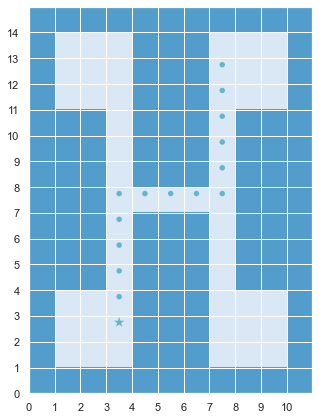

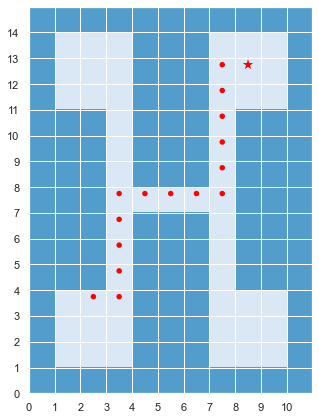

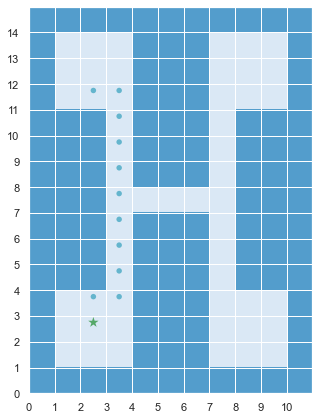

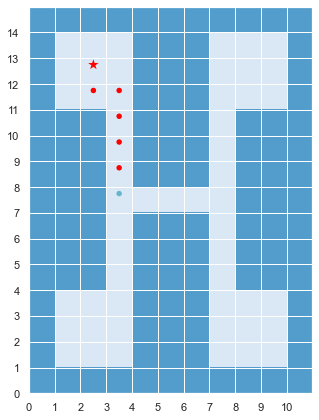

In [28]:
# results_file = '../results/test_predict/room_traj/centre_only_temp_1_0.1_context_4/pred_result_cp_1000.pth'
results_file = args.results_pkl_path
discrete_context = True
plot_type = 'pred_context'
def plot_pickle_results(results_pkl_path, obstacles, rooms,
                        num_traj_to_plot=1):
    assert os.path.exists(results_pkl_path), \
        'results pickle does not exist {}'.format(results_pkl_path)
    with open(results_pkl_path, 'rb') as results_f:
        results_dict = pickle.load(results_f)
        
        total_traj = len(results_dict['true_traj_state'])
        num_plot_traj = 0
        while num_plot_traj < num_traj_to_plot:
            # traj_idx = np.random.randint(total_traj)
            traj_idx = 2
            results_dict['true_goal'][traj_idx]

            goal_idx_list = get_multiple_traj_idx_from_goal_list(
                np.squeeze(results_dict['true_goal'][traj_idx]).tolist())
            # goal_idx_list = [(0, 50)]
            for goal_start_idx, goal_end_idx in goal_idx_list:
            
                traj_len = goal_end_idx - goal_start_idx
                true_traj, pred_traj = [], []
                pred_context_list = []
                          
                for j in range(traj_len):
                    x_true = (results_dict['true_traj_state'][traj_idx][goal_start_idx + j, 0, :]).tolist()
                    #TODO
                    x_pred = (results_dict['true_traj_state'][traj_idx][goal_start_idx + j, 0, :]).tolist()
                    true_traj.append(x_true)
                    pred_traj.append(x_pred)
                    if results_dict.get(plot_type) is not None:
                        if discrete_context:
                            pred_context = softmax(
                                results_dict[plot_type][traj_idx][goal_start_idx+j, 0, :]
                            )
                        else:
                            pred_context = results_dict[plot_type][traj_idx][goal_start_idx+j, 0, :]
                        pred_context_list.append(pred_context)
                
                # Plot trajectory
                plot_trajectory(np.array(true_traj),
                                (15, 11),
                                pred_traj_data=np.array(pred_traj),
                                color_map=sns.color_palette("Blues_r"),
                                figsize=(6, 6),
                                obstacles=obstacles,
                                rooms=rooms,
                                pred_context=pred_context_list,
                                pred_context_discrete=discrete_context,
                               )
                num_plot_traj += 1

plot_pickle_results(results_file, obstacles, rooms, num_traj_to_plot=1)